# PROJECT OVERVIEW

# Motivation:

This project aims to analyze online sentiment, for example, in social media
posts or during crisis communication scenarios. By understanding the
emotions expressed in text, we can gain insights into public opinion,
identify urgent needs, or track the emotional impact of events.

# Interesting Aspects:

- Introduction to Natural Language Processing (NLP)
- Discussable Language Bias
- Interesting Visualization Possible

# 1. IMPORT LIBRARIES

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import contractions # pip install contractions

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, LSTM, GRU, Embedding, Bidirectional,
                                     Input, GlobalMaxPooling1D, Attention,
                                     Layer, Dropout)

# Download necessary NLTK data
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)

True

# 2. CONFIGURATION PARAMETERS

In [ ]:
# --- Data Paths ---
DIR_PATH = '' # Base directory
DATASET_DIR = os.path.join(DIR_PATH, 'Dataset')
GLOVE_DIR = os.path.join(DIR_PATH, 'Glove')
TRAIN_FILE = os.path.join(DATASET_DIR, 'train.txt')
VAL_FILE = os.path.join(DATASET_DIR, 'val.txt')
TEST_FILE = os.path.join(DATASET_DIR, 'test.txt')
GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.200d.txt')

# --- Text Preprocessing ---
APPLY_CONTRACTION_FIX = True
MAX_LEN_PERCENTILE = 95 # Calculate max_len based on this percentile of sequence lengths

# --- Model Configuration ---
MODEL_TYPE = 'LSTM'        
USE_ATTENTION = False       # Attention adds computation.
EMBEDDING_DIM = 200         # Must match GloVe file.
RNN_UNITS_1 = 64
RNN_UNITS_2 = 32
DROPOUT_RATE = 0.25
RECURRENT_DROPOUT_RATE = 0.25
EMBEDDING_TRAINABLE = False # Keep False for speed; True fine-tunes GloVe.
LEARNING_RATE = 0.001

# --- Training Configuration ---
N_SPLITS_KFOLD = 3
EPOCHS = 15
BATCH_SIZE = 128
PATIENCE_EARLY_STOPPING = 3

# --- Plotting ---
SNS_FONT_SCALE = 1.1

# 3. GLOBAL VARIABLES & INITIAL SETUP

In [ ]:
STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()
sns.set(font_scale=SNS_FONT_SCALE)

print("TensorFlow Version:", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Available GPUs: {len(gpus)}")
    except RuntimeError as e:
        print(f"Error setting up GPU: {e}")
else:
    print("No GPU detected by TensorFlow. Training will be on CPU and may be very slow.")

TensorFlow Version: 2.13.0
No GPU detected by TensorFlow. Training will be on CPU and may be very slow.


# 4. TEXT PREPROCESSING FUNCTIONS

In [ ]:
def fix_contractions_text(text):
    if not text or not isinstance(text, str): return ""
    return contractions.fix(text)

def lower_case(text): return " ".join([y.lower() for y in str(text).split()])
def remove_stop_words_text(text): return " ".join([i for i in str(text).split() if i.lower() not in STOP_WORDS])
def removing_numbers_text(text): return ''.join([i for i in str(text) if not i.isdigit()])
def removing_punctuations_text(text):
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', str(text))
    text = re.sub(r'\s+', ' ', text); return text.strip()
def removing_urls_text(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+'); return url_pattern.sub(r'', str(text))
def lemmatization_text_func(text): return " ".join([LEMMATIZER.lemmatize(y) for y in str(text).split()])

def normalize_text_series(text_series):
    if APPLY_CONTRACTION_FIX: text_series = text_series.astype(str).apply(fix_contractions_text)
    text_series = text_series.astype(str).apply(lower_case)
    text_series = text_series.apply(removing_urls_text)
    text_series = text_series.apply(removing_punctuations_text)
    text_series = text_series.apply(removing_numbers_text)
    text_series = text_series.apply(remove_stop_words_text)
    text_series = text_series.apply(lemmatization_text_func)
    text_series.replace('', np.nan, inplace=True); return text_series

def normalize_sentence_string(sentence):
    if APPLY_CONTRACTION_FIX: sentence = fix_contractions_text(sentence)
    sentence = lower_case(sentence); sentence = removing_urls_text(sentence)
    sentence = removing_punctuations_text(sentence); sentence = removing_numbers_text(sentence)
    sentence = remove_stop_words_text(sentence); sentence = lemmatization_text_func(sentence)
    return sentence

# 5. LOAD AND PREPROCESS DATA

In [ ]:
print("Loading datasets...")
try:
    df_train_orig = pd.read_csv(TRAIN_FILE, names=['Text', 'Emotion'], sep=';')
    df_val_orig = pd.read_csv(VAL_FILE, names=['Text', 'Emotion'], sep=';')
    df_test_orig = pd.read_csv(TEST_FILE, names=['Text', 'Emotion'], sep=';')
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading datasets: {e}")
    # You might want to stop execution here in a real scenario
    df_full_train = pd.DataFrame() # Create empty dataframe to avoid errors later
else:
    df_full_train = pd.concat([df_train_orig, df_val_orig], ignore_index=True)
    df_test = df_test_orig.copy()

Loading datasets...
Datasets loaded successfully.


# 6. Exploratory Data Analysis (EDA) and Visualization


--- EDA: Full Training DataFrame (Original) ---
Shape: (18000, 2)
Emotion Counts (%):
Emotion
joy         33.700000
sadness     28.977778
anger       13.522222
fear        11.938889
love         8.233333
surprise     3.627778
Name: proportion, dtype: float64


C:\Users\omvag\AppData\Local\Temp\ipykernel_17880\674379683.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=df, ax=ax_emotion, palette="viridis")



--- EDA: Test DataFrame (Original) ---
Shape: (2000, 2)
Emotion Counts (%):
Emotion
joy         34.75
sadness     29.05
anger       13.75
fear        11.20
love         7.95
surprise     3.30
Name: proportion, dtype: float64


C:\Users\omvag\AppData\Local\Temp\ipykernel_17880\674379683.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=df, ax=ax_emotion, palette="viridis")


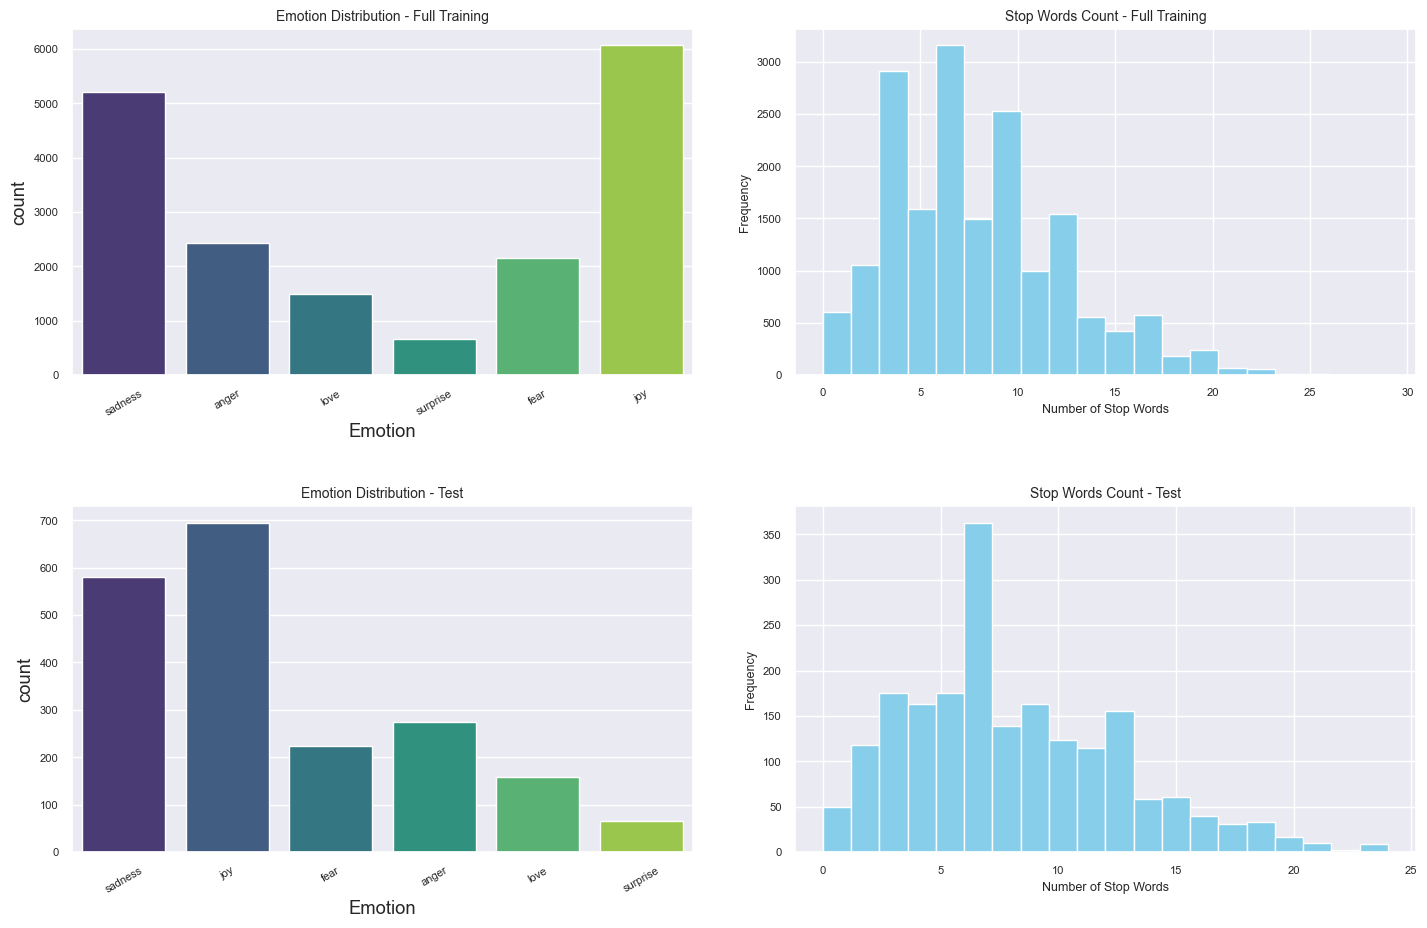

In [6]:
# --- EDA Plots ---
FIG_ROWS_EDA, FIG_COLS_EDA = 2, 2
FIG_WIDTH_EDA, FIG_HEIGHT_EDA = 15, 10
fig_eda, axes_eda_main = plt.subplots(FIG_ROWS_EDA, FIG_COLS_EDA, figsize=(FIG_WIDTH_EDA, FIG_HEIGHT_EDA))
axes_eda_flat = axes_eda_main.flatten()
eda_plot_idx = 0

def explore_dataframe_eda(df, df_name, ax_emotion, ax_stopwords):
    print(f"\n--- EDA: {df_name} DataFrame (Original) ---")
    print(f"Shape: {df.shape}")
    print(f"Emotion Counts (%):\n{df['Emotion'].value_counts(normalize=True) * 100}")
    sns.countplot(x='Emotion', data=df, ax=ax_emotion, palette="viridis")
    ax_emotion.set_title(f'Emotion Distribution - {df_name}', fontsize=10)
    ax_emotion.tick_params(axis='x', rotation=30, labelsize=8)
    ax_emotion.tick_params(axis='y', labelsize=8)

    df_temp_eda = df.copy()
    df_temp_eda['stop_words_count'] = df_temp_eda['Text'].apply(lambda x: len(set(str(x).split()) & STOP_WORDS))
    df_temp_eda['stop_words_count'].plot(kind='hist', ax=ax_stopwords, bins=20, color='skyblue')
    ax_stopwords.set_title(f'Stop Words Count - {df_name}', fontsize=10)
    ax_stopwords.set_xlabel('Number of Stop Words', fontsize=9)
    ax_stopwords.set_ylabel('Frequency', fontsize=9)
    ax_stopwords.tick_params(axis='both', labelsize=8)
    return df

if eda_plot_idx + 1 < len(axes_eda_flat):
    explore_dataframe_eda(df_full_train, "Full Training", axes_eda_flat[eda_plot_idx], axes_eda_flat[eda_plot_idx+1])
    eda_plot_idx += 2
if eda_plot_idx + 1 < len(axes_eda_flat):
    explore_dataframe_eda(df_test, "Test", axes_eda_flat[eda_plot_idx], axes_eda_flat[eda_plot_idx+1])
    eda_plot_idx += 2
for i in range(eda_plot_idx, len(axes_eda_flat)): fig_eda.delaxes(axes_eda_flat[i])
fig_eda.tight_layout(pad=2.5)
plt.show()

# 7. Data Cleaning and Label Encoding

In [7]:
# --- Apply Cleaning ---
print("\nNormalizing text data for combined training set...")
df_full_train['Text_Clean'] = normalize_text_series(df_full_train['Text'])
df_full_train.dropna(subset=['Text_Clean'], inplace=True)
df_full_train.drop_duplicates(subset=['Text_Clean', 'Emotion'], inplace=True)
df_full_train.reset_index(drop=True, inplace=True)

print("Normalizing text data for test set...")
df_test['Text_Clean'] = normalize_text_series(df_test['Text'])
df_test.dropna(subset=['Text_Clean'], inplace=True)
df_test.reset_index(drop=True, inplace=True)

X_text_cleaned = df_full_train['Text_Clean']
y_labels = df_full_train['Emotion']
X_test_final_text = df_test['Text_Clean']
y_test_labels_final = df_test['Emotion']

le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)
y_test_encoded_final = le.transform(y_test_labels_final)
num_classes = len(le.classes_)
print(f"Label encoder classes: {le.classes_}")


Normalizing text data for combined training set...
Normalizing text data for test set...
Label encoder classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


# 8. Text Tokenization and Sequence Padding

In [8]:
tokenizer = Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts(X_text_cleaned)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

all_train_sequences_for_len = tokenizer.texts_to_sequences(X_text_cleaned)
sequence_lengths = [len(seq) for seq in all_train_sequences_for_len if seq]
if sequence_lengths:
    max_len = int(np.percentile(sequence_lengths, MAX_LEN_PERCENTILE))
    if max_len == 0: max_len = 1 # Ensure max_len is at least 1
    print(f"Using MAX_LEN = {max_len} (based on {MAX_LEN_PERCENTILE}th percentile of training sequence lengths)")
else:
    max_len = 50 # Default if no sequences found
    print(f"Warning: No sequences found to calculate max_len. Defaulting to {max_len}.")

Vocabulary size: 14253
Using MAX_LEN = 19 (based on 95th percentile of training sequence lengths)


# 9. WORD EMBEDDINGS (GloVe)

In [ ]:
print("\n" + "="*3 + " Loading GloVe Word Embeddings " + "="*3)
embedding_index = {}
try:
    with open(GLOVE_FILE, encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embedding_index[word] = coefs
    print(f"Found {len(embedding_index)} word vectors in GloVe file.")
except FileNotFoundError:
    print(f"GloVe file not found: {GLOVE_FILE}. Using random embeddings if EMBEDDING_TRAINABLE=True."); embedding_index = {}

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
hits = 0; misses = 0
for word, i in tokenizer.word_index.items():
    if i < vocab_size: # Important check
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector; hits += 1
        else: misses += 1
print(f"GloVe: Converted {hits} words, missed {misses} words.")


=== Loading GloVe Word Embeddings ===
Found 400000 word vectors in GloVe file.
GloVe: Converted 13199 words, missed 1053 words.


# 10. MODEL DEFINITION


In [ ]:
def build_configured_model():
    text_input = Input(shape=(max_len,), name='text_input')
    use_pretrained_embeddings = len(embedding_index) > 0 and not EMBEDDING_TRAINABLE

    emb_layer = Embedding(
        input_dim=vocab_size, output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix] if use_pretrained_embeddings else None,
        input_length=max_len, trainable=EMBEDDING_TRAINABLE, name='embedding_layer'
    )(text_input)

    RecurrentLayer = GRU if MODEL_TYPE == 'GRU' else LSTM

    rnn1 = Bidirectional(RecurrentLayer(RNN_UNITS_1, dropout=DROPOUT_RATE, recurrent_dropout=RECURRENT_DROPOUT_RATE,
                                        return_sequences=True if USE_ATTENTION or RNN_UNITS_2 > 0 else False),
                                        name=f'bi_{MODEL_TYPE.lower()}_1')(emb_layer)

    if RNN_UNITS_2 > 0:
        rnn_output = Bidirectional(RecurrentLayer(RNN_UNITS_2, dropout=DROPOUT_RATE, recurrent_dropout=RECURRENT_DROPOUT_RATE,
                                                return_sequences=USE_ATTENTION),
                                        name=f'bi_{MODEL_TYPE.lower()}_2')(rnn1)
    else: # Only one RNN layer
        rnn_output = rnn1 # rnn1 was already set with appropriate return_sequences

    if USE_ATTENTION:
        att_out = Attention(name='self_attention_layer')([rnn_output, rnn_output])
        processed_rnn_output = GlobalMaxPooling1D(name='gmp_after_attention')(att_out)
    else:
        if len(rnn_output.shape) == 3 and rnn_output.shape[1] is not None: # Check if it's a sequence
            processed_rnn_output = GlobalMaxPooling1D(name='gmp_no_attention')(rnn_output)
        else:
            processed_rnn_output = rnn_output

    dropout_final = Dropout(DROPOUT_RATE)(processed_rnn_output)
    output_layer = Dense(num_classes, activation='softmax', name='output_softmax')(dropout_final)

    model = Model(inputs=text_input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("\nBuilding a sample model instance for summary...")
temp_model = build_configured_model()
temp_model.summary(line_length=120)
try:
    plot_model(temp_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    print("\nModel architecture plot saved to model_architecture.png")
except Exception as e:
    print(f"\nCould not plot model: {e}")


Building a sample model instance for summary...
Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 text_input (InputLayer)                              [(None, 19)]                                    0                 
                                                                                                                        
 embedding_layer (Embedding)                          (None, 19, 200)                                 2850600           
                                                                                                                        
 bi_lstm_1 (Bidirectional)                            (None, 19, 128)                                 135680            
                                                                                         

# 11. K-FOLD CROSS-VALIDATION TRAINING


=== K-Fold Cross-Validation Training ===

--- Fold 1/3 ---
Class weights for fold 1: {0: 1.2380952380952381, 1: 1.394706020145233, 2: 0.4933300190570884, 3: 2.018989487962021, 4: 0.5762679055361982, 5: 4.594135802469136}
Training on 11908 samples, validating on 5954 samples...
Epoch 1/15
94/94 [==============================] - 26s 191ms/step - loss: 1.5447 - accuracy: 0.3631 - val_loss: 1.2151 - val_accuracy: 0.5316
Epoch 2/15
94/94 [==============================] - 16s 168ms/step - loss: 1.0507 - accuracy: 0.5658 - val_loss: 0.8839 - val_accuracy: 0.6864
Epoch 3/15
94/94 [==============================] - 16s 172ms/step - loss: 0.7689 - accuracy: 0.6799 - val_loss: 0.7234 - val_accuracy: 0.7410
Epoch 4/15
94/94 [==============================] - 16s 173ms/step - loss: 0.6192 - accuracy: 0.7458 - val_loss: 0.5679 - val_accuracy: 0.7986
Epoch 5/15
94/94 [==============================] - 16s 174ms/step - loss: 0.5220 - accuracy: 0.7831 - val_loss: 0.5016 - val_accuracy: 0.8226
Epoch 

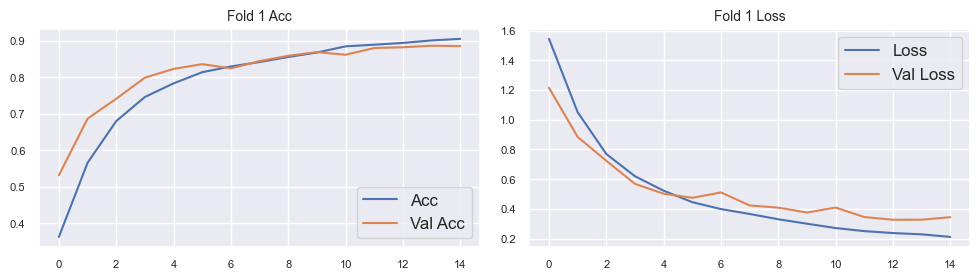


--- Fold 2/3 ---
Class weights for fold 2: {0: 1.2388680815647108, 1: 1.395686826066573, 2: 0.4933300190570884, 3: 2.0169376693766936, 4: 0.5761006289308176, 5: 4.594135802469136}
Training on 11908 samples, validating on 5954 samples...
Epoch 1/15
94/94 [==============================] - 26s 181ms/step - loss: 1.5231 - accuracy: 0.3515 - val_loss: 1.1884 - val_accuracy: 0.5403
Epoch 2/15
94/94 [==============================] - 15s 157ms/step - loss: 1.0341 - accuracy: 0.5694 - val_loss: 0.8721 - val_accuracy: 0.6866
Epoch 3/15
94/94 [==============================] - 15s 162ms/step - loss: 0.8063 - accuracy: 0.6718 - val_loss: 0.7886 - val_accuracy: 0.7130
Epoch 4/15
94/94 [==============================] - 15s 165ms/step - loss: 0.6658 - accuracy: 0.7252 - val_loss: 0.6972 - val_accuracy: 0.7514
Epoch 5/15
94/94 [==============================] - 15s 160ms/step - loss: 0.5604 - accuracy: 0.7635 - val_loss: 0.5416 - val_accuracy: 0.8005
Epoch 6/15
94/94 [=============================

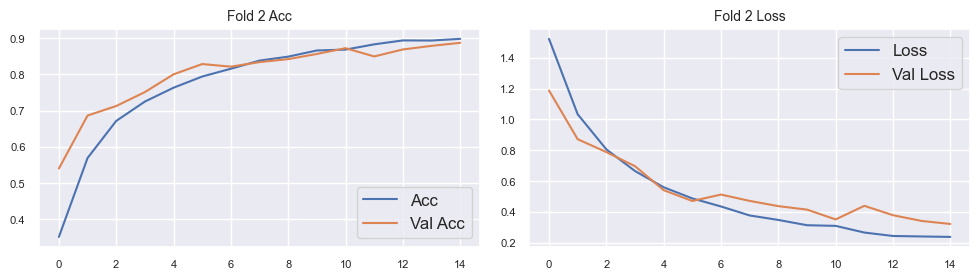


--- Fold 3/3 ---
Class weights for fold 3: {0: 1.2380952380952381, 1: 1.394706020145233, 2: 0.49345267694347755, 3: 2.018989487962021, 4: 0.5761006289308176, 5: 4.594135802469136}
Training on 11908 samples, validating on 5954 samples...
Epoch 1/15
94/94 [==============================] - 27s 190ms/step - loss: 1.5377 - accuracy: 0.3304 - val_loss: 1.2658 - val_accuracy: 0.4876
Epoch 2/15
94/94 [==============================] - 14s 153ms/step - loss: 1.0659 - accuracy: 0.5652 - val_loss: 0.9853 - val_accuracy: 0.6349
Epoch 3/15
94/94 [==============================] - 15s 157ms/step - loss: 0.7853 - accuracy: 0.6853 - val_loss: 0.7812 - val_accuracy: 0.7241
Epoch 4/15
94/94 [==============================] - 15s 161ms/step - loss: 0.6287 - accuracy: 0.7445 - val_loss: 0.8844 - val_accuracy: 0.6821
Epoch 5/15
94/94 [==============================] - 15s 164ms/step - loss: 0.5704 - accuracy: 0.7586 - val_loss: 0.5641 - val_accuracy: 0.8015
Epoch 6/15
94/94 [=============================

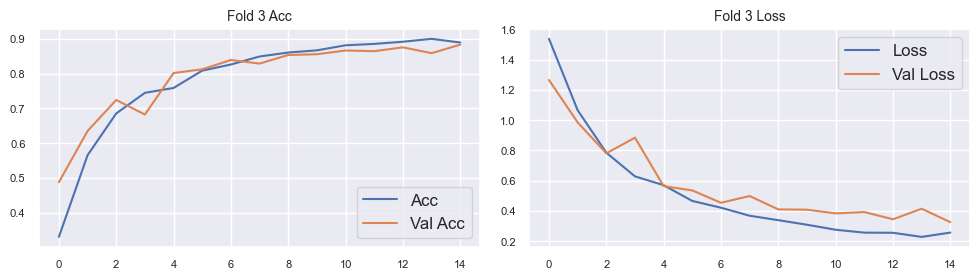


--- K-Fold CV Summary ---
Avg Val Acc: 0.8852 (+/- 0.0018)
Avg Val Loss: 0.3307


In [ ]:
print("\n" + "="*3 + " K-Fold Cross-Validation Training " + "="*3)
kf = StratifiedKFold(n_splits=N_SPLITS_KFOLD, shuffle=True, random_state=42)
fold_val_accuracies, fold_val_losses = [], []
histories = []

# Prepare test data sequences once
X_test_sequences_final = tokenizer.texts_to_sequences(X_test_final_text)
X_test_padded_final = pad_sequences(X_test_sequences_final, maxlen=max_len, padding='post', truncating='pre')
y_test_one_hot_final = to_categorical(y_test_encoded_final, num_classes=num_classes)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_text_cleaned, y_encoded)):
    print(f"\n--- Fold {fold+1}/{N_SPLITS_KFOLD} ---")
    X_train_fold_text, X_val_fold_text = X_text_cleaned.iloc[train_idx], X_text_cleaned.iloc[val_idx]
    y_train_fold_encoded, y_val_fold_encoded = y_encoded[train_idx], y_encoded[val_idx]

    X_train_seq = tokenizer.texts_to_sequences(X_train_fold_text)
    X_val_seq = tokenizer.texts_to_sequences(X_val_fold_text)
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='pre')
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='pre')
    y_train_oh = to_categorical(y_train_fold_encoded, num_classes=num_classes)
    y_val_oh = to_categorical(y_val_fold_encoded, num_classes=num_classes)

    class_weights_fold = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_fold_encoded), y=y_train_fold_encoded)
    class_weights_dict = dict(enumerate(class_weights_fold))
    print(f"Class weights for fold {fold+1}: {class_weights_dict}")

    model_fold = build_configured_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLY_STOPPING, restore_best_weights=True, verbose=1)

    print(f"Training on {len(X_train_pad)} samples, validating on {len(X_val_pad)} samples...")
    history = model_fold.fit(X_train_pad, y_train_oh, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                validation_data=(X_val_pad, y_val_oh), class_weight=class_weights_dict,
                                callbacks=[early_stop], verbose=1)
    histories.append(history)

    loss, acc = model_fold.evaluate(X_val_pad, y_val_oh, verbose=0)
    print(f"Fold {fold+1} - Val Loss: {loss:.4f}, Val Acc: {acc:.4f}")
    fold_val_accuracies.append(acc); fold_val_losses.append(loss)

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1); plt.plot(history.history['accuracy'], label='Acc'); plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold+1} Acc', fontsize=10); plt.legend(); plt.tick_params(labelsize=8)
    plt.subplot(1, 2, 2); plt.plot(history.history['loss'], label='Loss'); plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold+1} Loss', fontsize=10); plt.legend(); plt.tick_params(labelsize=8)
    plt.tight_layout(); plt.show()

print("\n--- K-Fold CV Summary ---")
print(f"Avg Val Acc: {np.mean(fold_val_accuracies):.4f} (+/- {np.std(fold_val_accuracies):.4f})")
print(f"Avg Val Loss: {np.mean(fold_val_losses):.4f}")

# 12. FINAL MODEL TRAINING (on full data)


In [ ]:
print("\n" + "="*3 + " Training Final Model on Full Training Data " + "="*3)
X_full_train_seq = tokenizer.texts_to_sequences(X_text_cleaned)
X_full_train_pad = pad_sequences(X_full_train_seq, maxlen=max_len, padding='post', truncating='pre')
y_full_train_oh = to_categorical(y_encoded, num_classes=num_classes)

full_cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
full_cw_dict = dict(enumerate(full_cw))
print(f"Class weights for final model: {full_cw_dict}")

final_model = build_configured_model()
final_early_stop = EarlyStopping(monitor='loss', patience=PATIENCE_EARLY_STOPPING // 2 + 1, verbose=1, restore_best_weights=True)
print(f"Training final model on {len(X_full_train_pad)} samples...")
final_model.fit(X_full_train_pad, y_full_train_oh, epochs=EPOCHS, batch_size=BATCH_SIZE,
                class_weight=full_cw_dict, callbacks=[final_early_stop], verbose=1)


=== Training Final Model on Full Training Data ===
Class weights for final model: {0: 1.2383527454242929, 1: 1.395032802249297, 2: 0.49337089824328806, 3: 2.0183050847457626, 4: 0.576156377007935, 5: 4.594135802469136}
Training final model on 17862 samples...
Epoch 1/15
140/140 [==============================] - 29s 152ms/step - loss: 1.3953 - accuracy: 0.4203
Epoch 2/15
140/140 [==============================] - 19s 139ms/step - loss: 0.8366 - accuracy: 0.6586
Epoch 3/15
140/140 [==============================] - 19s 135ms/step - loss: 0.6062 - accuracy: 0.7522
Epoch 4/15
140/140 [==============================] - 19s 138ms/step - loss: 0.4727 - accuracy: 0.8065
Epoch 5/15
140/140 [==============================] - 19s 136ms/step - loss: 0.4031 - accuracy: 0.8307
Epoch 6/15
140/140 [==============================] - 19s 138ms/step - loss: 0.3548 - accuracy: 0.8530
Epoch 7/15
140/140 [==============================] - 19s 137ms/step - loss: 0.3106 - accuracy: 0.8680
Epoch 8/15
140/140

# 13. FINAL MODEL EVALUATION & PREDICTION



=== Evaluating Final Model on Test Set ===
Test Set - Loss: 0.2543, Accuracy: 0.9000
63/63 [==============================] - 2s 13ms/step

Classification Report (Test Set - Final Model):
              precision    recall  f1-score   support

       anger       0.86      0.95      0.90       275
        fear       0.92      0.84      0.88       224
         joy       0.95      0.87      0.91       695
        love       0.72      0.95      0.82       159
     sadness       0.96      0.91      0.94       581
    surprise       0.65      0.94      0.77        66

    accuracy                           0.90      2000
   macro avg       0.84      0.91      0.87      2000
weighted avg       0.91      0.90      0.90      2000



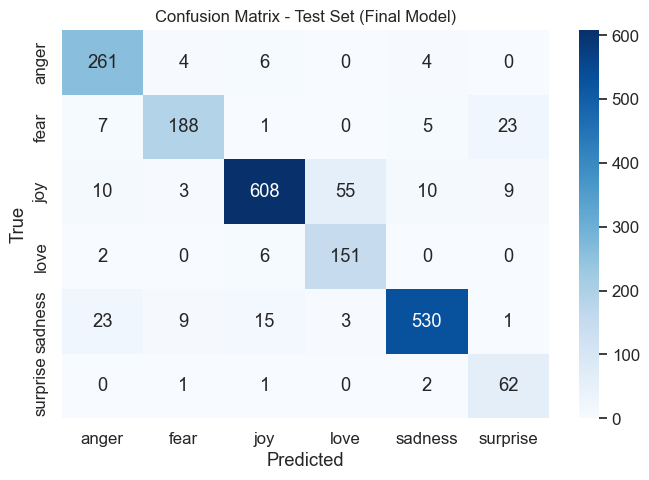

In [ ]:
print("\n" + "="*3 + " Evaluating Final Model on Test Set " + "="*3)
loss_t, acc_t = final_model.evaluate(X_test_padded_final, y_test_one_hot_final, verbose=0)
print(f"Test Set - Loss: {loss_t:.4f}, Accuracy: {acc_t:.4f}")

pred_probs_test = final_model.predict(X_test_padded_final)
pred_indices_test = np.argmax(pred_probs_test, axis=-1)
print("\nClassification Report (Test Set - Final Model):")
print(classification_report(y_test_labels_final, le.inverse_transform(pred_indices_test), target_names=le.classes_))

cm_final = confusion_matrix(y_test_labels_final, le.inverse_transform(pred_indices_test), labels=le.classes_)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set (Final Model)', fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# 14. Prediction on Custom Sentences

In [14]:
print("\n" + "="*3 + " Predicting on Custom Sentences " + "="*3)
custom_sentences = [
    "He's over the moon about being accepted to the university",
    "I am absolutely furious about what happened.",
    "This is a very sad and depressing situation.",
    "I feel so happy and joyful today!",
    "I can't do it, I'm not ready to lose anything, just leave me alone"
]
for sentence in custom_sentences:
    print(f"\nOriginal: {sentence}")
    norm_s = normalize_sentence_string(sentence)
    if not norm_s.strip():
        print("Sentence empty after normalization.")
        continue
    seq_s = tokenizer.texts_to_sequences([norm_s])
    pad_s = pad_sequences(seq_s, maxlen=max_len, padding='post', truncating='pre')
    pred_s = final_model.predict(pad_s, verbose=0)
    idx_s = np.argmax(pred_s, axis=-1)[0]
    lbl_s = le.inverse_transform([idx_s])[0]
    prob_s = np.max(pred_s)
    print(f"Normalized: {norm_s}\nPredicted: {lbl_s} (Confidence: {prob_s:.4f})")


=== Predicting on Custom Sentences ===

Original: He's over the moon about being accepted to the university
Normalized: moon accepted university
Predicted: joy (Confidence: 0.9643)

Original: I am absolutely furious about what happened.
Normalized: absolutely furious happened
Predicted: anger (Confidence: 0.9725)

Original: This is a very sad and depressing situation.
Normalized: sad depressing situation
Predicted: sadness (Confidence: 0.9966)

Original: I feel so happy and joyful today!
Normalized: feel happy joyful today
Predicted: joy (Confidence: 0.9995)

Original: I can't do it, I'm not ready to lose anything, just leave me alone
Normalized: cannot ready lose anything leave alone
Predicted: sadness (Confidence: 0.5915)


# 15. SAVE FINAL MODEL AND ARTIFACTS


In [ ]:
print("\n" + "="*3 + " Saving Final Model and Artifacts " + "="*3)
MODEL_SAVE_PATH = 'Emotion_Recognition_Final_Model.keras'
TOKENIZER_SAVE_PATH = 'tokenizer.json'
LABEL_ENCODER_SAVE_PATH = 'label_encoder.npy'
import json

try:
    final_model.save(MODEL_SAVE_PATH)
    print(f"Final model saved to {MODEL_SAVE_PATH}")

    tokenizer_json = tokenizer.to_json()
    with open(TOKENIZER_SAVE_PATH, 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    print(f"Tokenizer saved to {TOKENIZER_SAVE_PATH}")

    np.save(LABEL_ENCODER_SAVE_PATH, le.classes_)
    print(f"Label encoder classes saved to {LABEL_ENCODER_SAVE_PATH}")

except Exception as e:
    print(f"Error saving model/artifacts: {e}")

print("\nScript finished.")


=== Saving Final Model and Artifacts ===
Final model saved to Emotion_Recognition_Final_Model.keras
Tokenizer saved to tokenizer.json
Label encoder classes saved to label_encoder.npy

Script finished.


# 16. LOAD FINAL MODEL AND ARTIFACTS FOR GUI

In [ ]:
import tkinter as tk
from tkinter import scrolledtext, ttk
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json

print("\n" + "="*3 + " Initializing GUI for Emotion Prediction " + "="*3)

# --- Paths to saved artifacts ---
GUI_MODEL_PATH = 'Emotion_Recognition_Final_Model.keras'
GUI_TOKENIZER_PATH = 'tokenizer.json'
GUI_LABEL_ENCODER_PATH = 'label_encoder.npy'

# --- Load Model and Artifacts ---
loaded_model_gui = None
loaded_tokenizer_gui = None
loaded_label_encoder_classes_gui = None
is_gui_ready = False

try:
    # 1. Load the trained model
    if os.path.exists(GUI_MODEL_PATH):
        loaded_model_gui = load_model(GUI_MODEL_PATH)
        print(f"Model loaded successfully from {GUI_MODEL_PATH}")
    else:
        print(f"ERROR: Model file not found at {GUI_MODEL_PATH}")

    # 2. Load the tokenizer
    if os.path.exists(GUI_TOKENIZER_PATH):
        with open(GUI_TOKENIZER_PATH, 'r', encoding='utf-8') as f:
            tokenizer_json_gui = json.load(f)
            loaded_tokenizer_gui = tokenizer_from_json(tokenizer_json_gui)
        print(f"Tokenizer loaded successfully from {GUI_TOKENIZER_PATH}")
    else:
        print(f"ERROR: Tokenizer file not found at {GUI_TOKENIZER_PATH}")

    # 3. Load the label encoder classes
    if os.path.exists(GUI_LABEL_ENCODER_PATH):
        loaded_label_encoder_classes_gui = np.load(GUI_LABEL_ENCODER_PATH, allow_pickle=True)
        print(f"Label encoder classes loaded successfully from {GUI_LABEL_ENCODER_PATH}")
    else:
        print(f"ERROR: Label encoder file not found at {GUI_LABEL_ENCODER_PATH}")

    # 4. Check if max_len is available from a previous cell
    if 'max_len' not in globals() or not isinstance(max_len, int) or max_len == 0:
         print(f"ERROR: 'max_len' is not defined or invalid. Please ensure it is set from a previous cell.")
    
    if loaded_model_gui and loaded_tokenizer_gui and loaded_label_encoder_classes_gui is not None and 'max_len' in globals():
        is_gui_ready = True
        print("GUI is ready for predictions.")
    else:
        print("GUI initialization failed. Please ensure model, tokenizer, and label encoder files exist and 'max_len' is set.")

except Exception as e:
    print(f"An error occurred during GUI initialization: {e}")
    is_gui_ready = False


=== Initializing GUI for Emotion Prediction ===
Model loaded successfully from Emotion_Recognition_Final_Model.keras
Tokenizer loaded successfully from tokenizer.json
Label encoder classes loaded successfully from label_encoder.npy
GUI is ready for predictions.


# 17. GUI APPLICATION CODE

In [ ]:
# --- Prediction Function for GUI ---
def predict_emotion_gui(sentence_text):
    if not is_gui_ready:
        return "Error: GUI not ready.", 0.0
    
    normalized_sentence = normalize_sentence_string(sentence_text) # Uses function from a previous cell
    if not normalized_sentence.strip():
        return "Empty after normalization", 0.0

    sequence = loaded_tokenizer_gui.texts_to_sequences([normalized_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='pre')
    
    prediction_probs = loaded_model_gui.predict(padded_sequence, verbose=0)
    predicted_index = np.argmax(prediction_probs, axis=-1)[0]
    predicted_label = loaded_label_encoder_classes_gui[predicted_index]
    confidence_score = np.max(prediction_probs)
    
    return predicted_label, confidence_score

# --- Tkinter GUI Application Class ---
class EmotionPredictorApp:
    def __init__(self, root_window):
        self.root = root_window
        self.root.title("Emotion Predictor")
        self.root.geometry("450x300")

        self.style = ttk.Style()
        self.style.theme_use('clam')
        
        main_frame = ttk.Frame(self.root, padding="10 10 10 10")
        main_frame.pack(expand=True, fill=tk.BOTH)

        input_label = ttk.Label(main_frame, text="Enter text to analyze:")
        input_label.pack(pady=(0, 5), anchor="w")

        self.text_input = scrolledtext.ScrolledText(main_frame, wrap=tk.WORD, height=5, width=50)
        self.text_input.pack(pady=5, expand=True, fill=tk.BOTH)
        self.text_input.focus()

        self.test_button = ttk.Button(main_frame, text="Test Emotion", command=self.on_test_button_click)
        self.test_button.pack(pady=10)
        if not is_gui_ready:
            self.test_button.config(state=tk.DISABLED)

        self.result_var = tk.StringVar()
        self.result_var.set("Predicted Emotion: N/A")
        result_label = ttk.Label(main_frame, textvariable=self.result_var, font=("Helvetica", 10))
        result_label.pack(pady=5, anchor="w")

    def on_test_button_click(self):
        user_text = self.text_input.get("1.0", tk.END).strip()
        if not user_text:
            self.result_var.set("Predicted Emotion: Please enter some text.")
            return

        emotion, confidence = predict_emotion_gui(user_text)
        self.result_var.set(f"Predicted Emotion: {emotion} (Confidence: {confidence:.2f})")

# --- Function to Start the GUI ---
def start_gui_application():
    if not is_gui_ready:
        print("Cannot start GUI: Initialization failed.")
        return
    
    root = tk.Tk()
    app = EmotionPredictorApp(root)
    root.mainloop()

# --- Run the GUI Application ---
start_gui_application()